In [39]:
# Choose which feature to predict:
features_out = ["prod_wind", "prod_solar"]

In [40]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display


sns.set_theme()

In [42]:
df = pd.read_pickle("..\data\preparedpickle4electricity+time_2017-2021.pkl")
df.head()
#df.to_csv("..\data\data_prepared.csv")

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2017-01-01 00:00:00+00:00,15498.0,0.0,2.504006e-13,1.000000,0.010364,0.999946,-60.908284,0.0
2017-01-01 01:00:00+00:00,15406.9,0.0,2.588190e-01,0.965926,0.011081,0.999939,-56.058615,0.0
2017-01-01 02:00:00+00:00,14922.3,0.0,5.000000e-01,0.866025,0.011798,0.999930,-48.554986,0.0
2017-01-01 03:00:00+00:00,15022.0,0.0,7.071068e-01,0.707107,0.012515,0.999922,-39.734647,0.0
2017-01-01 04:00:00+00:00,15234.0,0.0,8.660254e-01,0.500000,0.013231,0.999912,-30.400744,0.0


In [43]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

num_features = len(features_out)

In [44]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

In [45]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [46]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [47]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Add last point of input array to label and prediction arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs[n, :, plot_col_index][-1])

        plt.plot(label_indices_plot, labels_plot, 'C2',
                 label='Labels', marker='.', zorder=1)
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot

In [48]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [49]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['prod_wind', 'prod_solar']

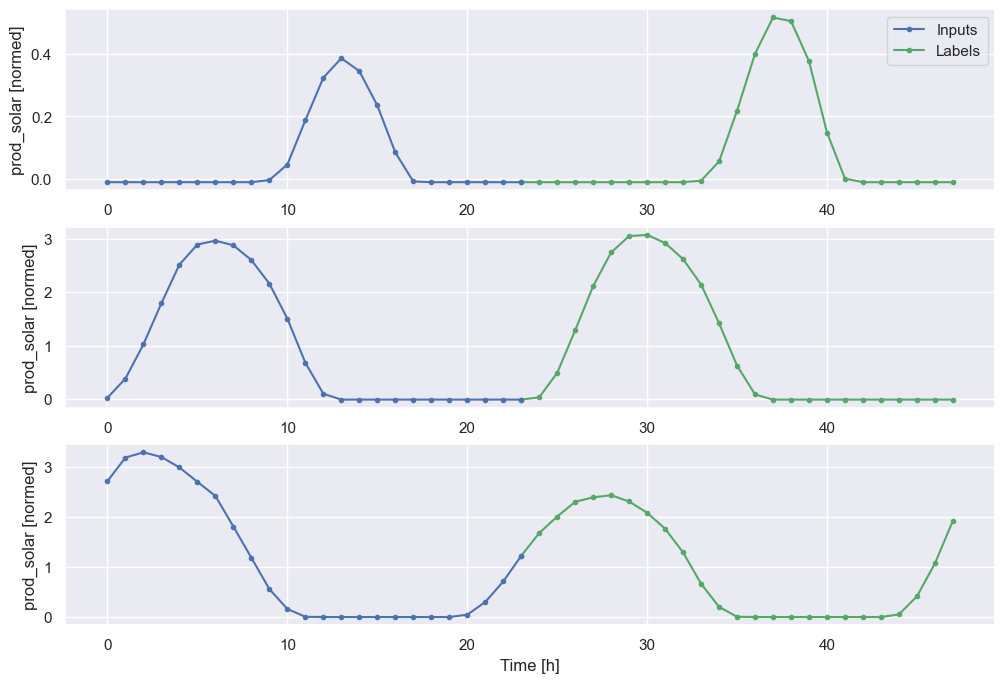

In [50]:
IN_STEPS = 24
OUT_STEPS = 24

multi_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=features_out)

multi_window.plot()
multi_window

In [51]:
MAX_EPOCHS = 5


def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      verbose=1)

    model.compile(loss='mse', optimizer='adam', metrics=['mae', RSquare()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [52]:
def build_model(params):
    lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        for i in r
        tf.keras.layers.LSTM(params['n_unit'], return_sequences=True),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.LSTM(params['n_unit'], return_sequences=True),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.LSTM(params['n_unit'], return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return lstm_model

273/273 [==============================] - 2s 5ms/step - loss: 0.1444 - mae: 0.2539 - r_square: 0.7704


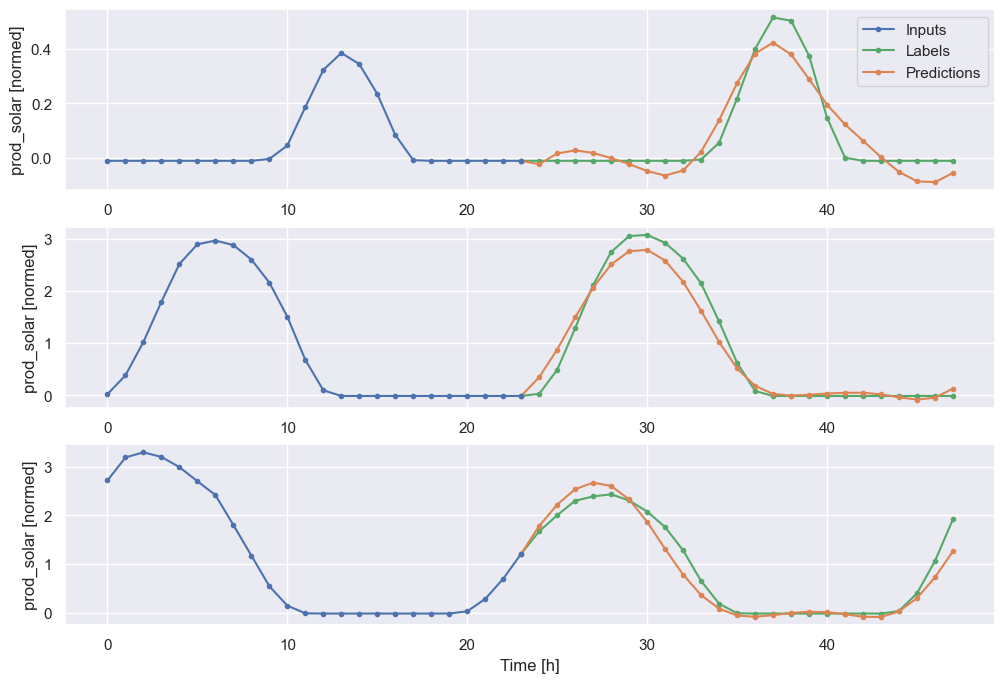

In [53]:
from tensorflow_addons.metrics.r_square import RSquare
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(lstm_model, multi_window)

IPython.display.clear_output()

val_performance = {}
test_performance = {}

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
testvalue = lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(lstm_model)

In [54]:
testvalue = testvalue[2]

In [57]:
import optuna as optuna
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              #'n_layer': trial.suggest_int("n_unit", 1, 5)
              }
    
    model = build_model(params)
    history = compile_and_fit(model, multi_window)
    
    accuracy = model.evaluate(multi_window.test, verbose=0)
    r2score = accuracy[2]

    return r2score

In [58]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-10-12 16:11:48,558] A new study created in memory with name: no-name-f1fa92c0-a253-49de-bc8b-9aadd25b0a90


Epoch 1/5


C:\Users\Dilara\AppData\Local\Temp\ipykernel_23228\2791352016.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


958/958 [==============================] - 19s 15ms/step - loss: 0.3147 - mae: 0.4101 - r_square: 0.5454 - val_loss: 0.2227 - val_mae: 0.3415 - val_r_square: 0.6746
Epoch 2/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1583 - mae: 0.2831 - r_square: 0.7454 - val_loss: 0.1705 - val_mae: 0.2822 - val_r_square: 0.7352
Epoch 3/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1406 - mae: 0.2576 - r_square: 0.7711 - val_loss: 0.1604 - val_mae: 0.2690 - val_r_square: 0.7472
Epoch 4/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1343 - mae: 0.2495 - r_square: 0.7805 - val_loss: 0.1504 - val_mae: 0.2641 - val_r_square: 0.7620
Epoch 5/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1310 - mae: 0.2450 - r_square: 0.7855 - val_loss: 0.1466 - val_mae: 0.2587 - val_r_square: 0.7658


[I 2022-10-12 16:13:03,109] Trial 0 finished with value: 0.7478506565093994 and parameters: {'learning_rate': 0.03525651726843779, 'optimizer': 'RMSprop', 'n_unit': 17}. Best is trial 0 with value: 0.7478506565093994.


Epoch 1/5
958/958 [==============================] - 16s 14ms/step - loss: 0.3462 - mae: 0.4303 - r_square: 0.5050 - val_loss: 0.2329 - val_mae: 0.3601 - val_r_square: 0.6611
Epoch 2/5
958/958 [==============================] - 12s 13ms/step - loss: 0.1700 - mae: 0.2998 - r_square: 0.7294 - val_loss: 0.1764 - val_mae: 0.2995 - val_r_square: 0.7279
Epoch 3/5
958/958 [==============================] - 12s 13ms/step - loss: 0.1484 - mae: 0.2686 - r_square: 0.7596 - val_loss: 0.1613 - val_mae: 0.2796 - val_r_square: 0.7468
Epoch 4/5
958/958 [==============================] - 12s 13ms/step - loss: 0.1406 - mae: 0.2581 - r_square: 0.7712 - val_loss: 0.1546 - val_mae: 0.2738 - val_r_square: 0.7556
Epoch 5/5
958/958 [==============================] - 12s 13ms/step - loss: 0.1359 - mae: 0.2524 - r_square: 0.7780 - val_loss: 0.1498 - val_mae: 0.2672 - val_r_square: 0.7619


[I 2022-10-12 16:14:09,443] Trial 1 finished with value: 0.7436646819114685 and parameters: {'learning_rate': 6.873881064329392e-05, 'optimizer': 'SGD', 'n_unit': 12}. Best is trial 0 with value: 0.7478506565093994.


Epoch 1/5
958/958 [==============================] - 17s 14ms/step - loss: 0.3677 - mae: 0.4401 - r_square: 0.4871 - val_loss: 0.2159 - val_mae: 0.3374 - val_r_square: 0.6858
Epoch 2/5
958/958 [==============================] - 13s 13ms/step - loss: 0.1584 - mae: 0.2839 - r_square: 0.7465 - val_loss: 0.1651 - val_mae: 0.2795 - val_r_square: 0.7447
Epoch 3/5
958/958 [==============================] - 12s 13ms/step - loss: 0.1414 - mae: 0.2588 - r_square: 0.7706 - val_loss: 0.1539 - val_mae: 0.2648 - val_r_square: 0.7582
Epoch 4/5
958/958 [==============================] - 13s 14ms/step - loss: 0.1357 - mae: 0.2513 - r_square: 0.7791 - val_loss: 0.1499 - val_mae: 0.2627 - val_r_square: 0.7646
Epoch 5/5
958/958 [==============================] - 13s 14ms/step - loss: 0.1322 - mae: 0.2471 - r_square: 0.7841 - val_loss: 0.1464 - val_mae: 0.2577 - val_r_square: 0.7680


[I 2022-10-12 16:15:18,396] Trial 2 finished with value: 0.7479808926582336 and parameters: {'learning_rate': 0.002096098374307469, 'optimizer': 'SGD', 'n_unit': 16}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 18s 14ms/step - loss: 0.5556 - mae: 0.5513 - r_square: 0.2673 - val_loss: 0.5205 - val_mae: 0.5259 - val_r_square: 0.3889
Epoch 2/5
958/958 [==============================] - 13s 14ms/step - loss: 0.2570 - mae: 0.3805 - r_square: 0.6260 - val_loss: 0.2474 - val_mae: 0.3702 - val_r_square: 0.6588
Epoch 3/5
958/958 [==============================] - 13s 14ms/step - loss: 0.2000 - mae: 0.3391 - r_square: 0.7004 - val_loss: 0.2212 - val_mae: 0.3534 - val_r_square: 0.6915
Epoch 4/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1818 - mae: 0.3201 - r_square: 0.7235 - val_loss: 0.1931 - val_mae: 0.3212 - val_r_square: 0.7195
Epoch 5/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1577 - mae: 0.2873 - r_square: 0.7515 - val_loss: 0.1680 - val_mae: 0.2913 - val_r_square: 0.7438


[I 2022-10-12 16:16:30,934] Trial 3 finished with value: 0.7260934710502625 and parameters: {'learning_rate': 0.002523295569558483, 'optimizer': 'Adam', 'n_unit': 7}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 17s 14ms/step - loss: 0.3441 - mae: 0.4270 - r_square: 0.5142 - val_loss: 0.2229 - val_mae: 0.3498 - val_r_square: 0.6819
Epoch 2/5
958/958 [==============================] - 13s 14ms/step - loss: 0.1636 - mae: 0.2920 - r_square: 0.7407 - val_loss: 0.1662 - val_mae: 0.2857 - val_r_square: 0.7431
Epoch 3/5
958/958 [==============================] - 13s 14ms/step - loss: 0.1436 - mae: 0.2613 - r_square: 0.7673 - val_loss: 0.1543 - val_mae: 0.2688 - val_r_square: 0.7584
Epoch 4/5
958/958 [==============================] - 13s 14ms/step - loss: 0.1373 - mae: 0.2530 - r_square: 0.7763 - val_loss: 0.1500 - val_mae: 0.2642 - val_r_square: 0.7644
Epoch 5/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1334 - mae: 0.2481 - r_square: 0.7821 - val_loss: 0.1466 - val_mae: 0.2604 - val_r_square: 0.7688


[I 2022-10-12 16:17:41,843] Trial 4 finished with value: 0.7468083500862122 and parameters: {'learning_rate': 6.466454140118623e-05, 'optimizer': 'SGD', 'n_unit': 14}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 20s 16ms/step - loss: 0.4376 - mae: 0.4835 - r_square: 0.3913 - val_loss: 0.3062 - val_mae: 0.4169 - val_r_square: 0.5692
Epoch 2/5
958/958 [==============================] - 15s 15ms/step - loss: 0.2239 - mae: 0.3620 - r_square: 0.6601 - val_loss: 0.2431 - val_mae: 0.3698 - val_r_square: 0.6559
Epoch 3/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1949 - mae: 0.3337 - r_square: 0.7023 - val_loss: 0.2086 - val_mae: 0.3379 - val_r_square: 0.6966
Epoch 4/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1665 - mae: 0.2967 - r_square: 0.7374 - val_loss: 0.1760 - val_mae: 0.2999 - val_r_square: 0.7309
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1488 - mae: 0.2704 - r_square: 0.7599 - val_loss: 0.1611 - val_mae: 0.2794 - val_r_square: 0.7487


[I 2022-10-12 16:19:01,386] Trial 5 finished with value: 0.7314273715019226 and parameters: {'learning_rate': 1.0786176868709613e-05, 'optimizer': 'SGD', 'n_unit': 8}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 19s 16ms/step - loss: 0.4080 - mae: 0.4667 - r_square: 0.4350 - val_loss: 0.2615 - val_mae: 0.3838 - val_r_square: 0.6341
Epoch 2/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1958 - mae: 0.3344 - r_square: 0.6998 - val_loss: 0.1963 - val_mae: 0.3185 - val_r_square: 0.7068
Epoch 3/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1552 - mae: 0.2791 - r_square: 0.7508 - val_loss: 0.1668 - val_mae: 0.2829 - val_r_square: 0.7419
Epoch 4/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1431 - mae: 0.2614 - r_square: 0.7678 - val_loss: 0.1584 - val_mae: 0.2704 - val_r_square: 0.7526
Epoch 5/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1377 - mae: 0.2542 - r_square: 0.7754 - val_loss: 0.1498 - val_mae: 0.2640 - val_r_square: 0.7623


[I 2022-10-12 16:20:20,130] Trial 6 finished with value: 0.7465419769287109 and parameters: {'learning_rate': 1.6997886836670655e-05, 'optimizer': 'Adam', 'n_unit': 11}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 19s 16ms/step - loss: 0.4901 - mae: 0.5172 - r_square: 0.3330 - val_loss: 0.3080 - val_mae: 0.4087 - val_r_square: 0.5780
Epoch 2/5
958/958 [==============================] - 14s 15ms/step - loss: 0.2211 - mae: 0.3584 - r_square: 0.6666 - val_loss: 0.2444 - val_mae: 0.3672 - val_r_square: 0.6593
Epoch 3/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1882 - mae: 0.3259 - r_square: 0.7122 - val_loss: 0.2021 - val_mae: 0.3279 - val_r_square: 0.7065
Epoch 4/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1615 - mae: 0.2906 - r_square: 0.7452 - val_loss: 0.1734 - val_mae: 0.2932 - val_r_square: 0.7356
Epoch 5/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1469 - mae: 0.2680 - r_square: 0.7634 - val_loss: 0.1647 - val_mae: 0.2786 - val_r_square: 0.7459


[I 2022-10-12 16:21:36,906] Trial 7 finished with value: 0.7311194539070129 and parameters: {'learning_rate': 0.0007860670423933193, 'optimizer': 'RMSprop', 'n_unit': 8}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 19s 16ms/step - loss: 0.4411 - mae: 0.4854 - r_square: 0.3967 - val_loss: 0.2754 - val_mae: 0.3880 - val_r_square: 0.6165
Epoch 2/5
958/958 [==============================] - 15s 16ms/step - loss: 0.2058 - mae: 0.3447 - r_square: 0.6875 - val_loss: 0.2206 - val_mae: 0.3500 - val_r_square: 0.6835
Epoch 3/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1740 - mae: 0.3088 - r_square: 0.7289 - val_loss: 0.1833 - val_mae: 0.3058 - val_r_square: 0.7234
Epoch 4/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1514 - mae: 0.2756 - r_square: 0.7571 - val_loss: 0.1641 - val_mae: 0.2826 - val_r_square: 0.7459
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1435 - mae: 0.2630 - r_square: 0.7680 - val_loss: 0.1573 - val_mae: 0.2729 - val_r_square: 0.7545


[I 2022-10-12 16:22:57,060] Trial 8 finished with value: 0.735968291759491 and parameters: {'learning_rate': 0.008974561573891973, 'optimizer': 'Adam', 'n_unit': 9}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 19s 16ms/step - loss: 0.5661 - mae: 0.5500 - r_square: 0.2474 - val_loss: 0.4933 - val_mae: 0.5046 - val_r_square: 0.4082
Epoch 2/5
958/958 [==============================] - 14s 15ms/step - loss: 0.2768 - mae: 0.3923 - r_square: 0.6006 - val_loss: 0.2654 - val_mae: 0.3829 - val_r_square: 0.6357
Epoch 3/5
958/958 [==============================] - 14s 15ms/step - loss: 0.2106 - mae: 0.3490 - r_square: 0.6838 - val_loss: 0.2377 - val_mae: 0.3612 - val_r_square: 0.6711
Epoch 4/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1973 - mae: 0.3366 - r_square: 0.7029 - val_loss: 0.2217 - val_mae: 0.3518 - val_r_square: 0.6894
Epoch 5/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1859 - mae: 0.3238 - r_square: 0.7178 - val_loss: 0.2081 - val_mae: 0.3342 - val_r_square: 0.7043


[I 2022-10-12 16:24:13,462] Trial 9 finished with value: 0.6868835091590881 and parameters: {'learning_rate': 0.0017644464696039822, 'optimizer': 'RMSprop', 'n_unit': 5}. Best is trial 2 with value: 0.7479808926582336.


Epoch 1/5
958/958 [==============================] - 21s 17ms/step - loss: 0.3383 - mae: 0.4260 - r_square: 0.5137 - val_loss: 0.2115 - val_mae: 0.3311 - val_r_square: 0.6811
Epoch 2/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1577 - mae: 0.2816 - r_square: 0.7451 - val_loss: 0.1650 - val_mae: 0.2812 - val_r_square: 0.7426
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1417 - mae: 0.2589 - r_square: 0.7693 - val_loss: 0.1562 - val_mae: 0.2749 - val_r_square: 0.7529
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1353 - mae: 0.2504 - r_square: 0.7790 - val_loss: 0.1481 - val_mae: 0.2621 - val_r_square: 0.7648
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1313 - mae: 0.2452 - r_square: 0.7852 - val_loss: 0.1437 - val_mae: 0.2562 - val_r_square: 0.7706


[I 2022-10-12 16:25:37,458] Trial 10 finished with value: 0.7506067156791687 and parameters: {'learning_rate': 0.08285687586652692, 'optimizer': 'SGD', 'n_unit': 18}. Best is trial 10 with value: 0.7506067156791687.


Epoch 1/5
958/958 [==============================] - 21s 18ms/step - loss: 0.3665 - mae: 0.4391 - r_square: 0.4894 - val_loss: 0.2202 - val_mae: 0.3454 - val_r_square: 0.6844
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1606 - mae: 0.2882 - r_square: 0.7454 - val_loss: 0.1662 - val_mae: 0.2865 - val_r_square: 0.7421
Epoch 3/5
958/958 [==============================] - 18s 19ms/step - loss: 0.1413 - mae: 0.2585 - r_square: 0.7708 - val_loss: 0.1525 - val_mae: 0.2660 - val_r_square: 0.7609
Epoch 4/5
958/958 [==============================] - 19s 20ms/step - loss: 0.1354 - mae: 0.2505 - r_square: 0.7793 - val_loss: 0.1481 - val_mae: 0.2603 - val_r_square: 0.7669
Epoch 5/5
958/958 [==============================] - 17s 17ms/step - loss: 0.1322 - mae: 0.2463 - r_square: 0.7837 - val_loss: 0.1451 - val_mae: 0.2556 - val_r_square: 0.7706


[I 2022-10-12 16:27:08,897] Trial 11 finished with value: 0.7508122324943542 and parameters: {'learning_rate': 0.09192191555743828, 'optimizer': 'SGD', 'n_unit': 18}. Best is trial 11 with value: 0.7508122324943542.


Epoch 1/5
958/958 [==============================] - 22s 18ms/step - loss: 0.2893 - mae: 0.3918 - r_square: 0.5677 - val_loss: 0.1977 - val_mae: 0.3213 - val_r_square: 0.6933
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1563 - mae: 0.2781 - r_square: 0.7458 - val_loss: 0.1607 - val_mae: 0.2764 - val_r_square: 0.7471
Epoch 3/5
958/958 [==============================] - 17s 18ms/step - loss: 0.1414 - mae: 0.2582 - r_square: 0.7691 - val_loss: 0.1509 - val_mae: 0.2665 - val_r_square: 0.7604
Epoch 4/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1350 - mae: 0.2499 - r_square: 0.7793 - val_loss: 0.1453 - val_mae: 0.2565 - val_r_square: 0.7684
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1315 - mae: 0.2453 - r_square: 0.7848 - val_loss: 0.1423 - val_mae: 0.2533 - val_r_square: 0.7722


[I 2022-10-12 16:28:37,139] Trial 12 finished with value: 0.7511382102966309 and parameters: {'learning_rate': 0.08989517925994712, 'optimizer': 'SGD', 'n_unit': 18}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 19s 15ms/step - loss: 0.3914 - mae: 0.4601 - r_square: 0.4536 - val_loss: 0.2448 - val_mae: 0.3691 - val_r_square: 0.6546
Epoch 2/5
958/958 [==============================] - 14s 15ms/step - loss: 0.1722 - mae: 0.3034 - r_square: 0.7294 - val_loss: 0.1695 - val_mae: 0.2875 - val_r_square: 0.7377
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1439 - mae: 0.2622 - r_square: 0.7669 - val_loss: 0.1579 - val_mae: 0.2729 - val_r_square: 0.7524
Epoch 4/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1374 - mae: 0.2535 - r_square: 0.7764 - val_loss: 0.1510 - val_mae: 0.2644 - val_r_square: 0.7623
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1331 - mae: 0.2482 - r_square: 0.7825 - val_loss: 0.1496 - val_mae: 0.2633 - val_r_square: 0.7645


[I 2022-10-12 16:29:57,655] Trial 13 finished with value: 0.7460396885871887 and parameters: {'learning_rate': 0.020256354309063238, 'optimizer': 'SGD', 'n_unit': 15}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 21s 17ms/step - loss: 0.3377 - mae: 0.4242 - r_square: 0.5211 - val_loss: 0.2171 - val_mae: 0.3463 - val_r_square: 0.6821
Epoch 2/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1580 - mae: 0.2821 - r_square: 0.7467 - val_loss: 0.1647 - val_mae: 0.2796 - val_r_square: 0.7435
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1406 - mae: 0.2570 - r_square: 0.7713 - val_loss: 0.1564 - val_mae: 0.2683 - val_r_square: 0.7538
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1342 - mae: 0.2490 - r_square: 0.7808 - val_loss: 0.1481 - val_mae: 0.2647 - val_r_square: 0.7641
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1309 - mae: 0.2447 - r_square: 0.7858 - val_loss: 0.1481 - val_mae: 0.2582 - val_r_square: 0.7663


[I 2022-10-12 16:31:22,031] Trial 14 finished with value: 0.7468498349189758 and parameters: {'learning_rate': 0.05834921759440798, 'optimizer': 'SGD', 'n_unit': 18}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3884 - mae: 0.4568 - r_square: 0.4604 - val_loss: 0.2412 - val_mae: 0.3682 - val_r_square: 0.6605
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1769 - mae: 0.3105 - r_square: 0.7250 - val_loss: 0.1718 - val_mae: 0.2933 - val_r_square: 0.7368
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1455 - mae: 0.2642 - r_square: 0.7650 - val_loss: 0.1587 - val_mae: 0.2738 - val_r_square: 0.7539
Epoch 4/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1391 - mae: 0.2547 - r_square: 0.7740 - val_loss: 0.1519 - val_mae: 0.2640 - val_r_square: 0.7615
Epoch 5/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1351 - mae: 0.2496 - r_square: 0.7797 - val_loss: 0.1471 - val_mae: 0.2613 - val_r_square: 0.7671


[I 2022-10-12 16:32:45,838] Trial 15 finished with value: 0.7467141151428223 and parameters: {'learning_rate': 0.010425387740285324, 'optimizer': 'SGD', 'n_unit': 13}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3371 - mae: 0.4259 - r_square: 0.5216 - val_loss: 0.2307 - val_mae: 0.3562 - val_r_square: 0.6677
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1644 - mae: 0.2933 - r_square: 0.7384 - val_loss: 0.1656 - val_mae: 0.2812 - val_r_square: 0.7413
Epoch 3/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1424 - mae: 0.2611 - r_square: 0.7689 - val_loss: 0.1559 - val_mae: 0.2686 - val_r_square: 0.7555
Epoch 4/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1358 - mae: 0.2520 - r_square: 0.7787 - val_loss: 0.1492 - val_mae: 0.2614 - val_r_square: 0.7634
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1321 - mae: 0.2471 - r_square: 0.7842 - val_loss: 0.1464 - val_mae: 0.2577 - val_r_square: 0.7690


[I 2022-10-12 16:34:10,166] Trial 16 finished with value: 0.7494020462036133 and parameters: {'learning_rate': 0.00037880280762534005, 'optimizer': 'SGD', 'n_unit': 16}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 21s 17ms/step - loss: 0.3327 - mae: 0.4206 - r_square: 0.5212 - val_loss: 0.2049 - val_mae: 0.3271 - val_r_square: 0.6889
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1555 - mae: 0.2780 - r_square: 0.7482 - val_loss: 0.1648 - val_mae: 0.2775 - val_r_square: 0.7430
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1398 - mae: 0.2567 - r_square: 0.7719 - val_loss: 0.1514 - val_mae: 0.2623 - val_r_square: 0.7602
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1331 - mae: 0.2483 - r_square: 0.7820 - val_loss: 0.1457 - val_mae: 0.2573 - val_r_square: 0.7671
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1295 - mae: 0.2436 - r_square: 0.7876 - val_loss: 0.1451 - val_mae: 0.2562 - val_r_square: 0.7695


[I 2022-10-12 16:35:34,958] Trial 17 finished with value: 0.7462535500526428 and parameters: {'learning_rate': 0.09889797985824256, 'optimizer': 'SGD', 'n_unit': 18}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 19s 16ms/step - loss: 0.3903 - mae: 0.4544 - r_square: 0.4522 - val_loss: 0.2540 - val_mae: 0.3799 - val_r_square: 0.6360
Epoch 2/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1881 - mae: 0.3250 - r_square: 0.7079 - val_loss: 0.1874 - val_mae: 0.3116 - val_r_square: 0.7162
Epoch 3/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1520 - mae: 0.2747 - r_square: 0.7549 - val_loss: 0.1652 - val_mae: 0.2818 - val_r_square: 0.7421
Epoch 4/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1427 - mae: 0.2602 - r_square: 0.7682 - val_loss: 0.1613 - val_mae: 0.2812 - val_r_square: 0.7467
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1383 - mae: 0.2545 - r_square: 0.7746 - val_loss: 0.1520 - val_mae: 0.2680 - val_r_square: 0.7596


[I 2022-10-12 16:36:55,392] Trial 18 finished with value: 0.7426629066467285 and parameters: {'learning_rate': 0.0075315251707948686, 'optimizer': 'RMSprop', 'n_unit': 11}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 21s 17ms/step - loss: 0.3530 - mae: 0.4363 - r_square: 0.4985 - val_loss: 0.2315 - val_mae: 0.3543 - val_r_square: 0.6682
Epoch 2/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1670 - mae: 0.2977 - r_square: 0.7356 - val_loss: 0.1697 - val_mae: 0.2884 - val_r_square: 0.7381
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1434 - mae: 0.2634 - r_square: 0.7677 - val_loss: 0.1547 - val_mae: 0.2720 - val_r_square: 0.7571
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1365 - mae: 0.2536 - r_square: 0.7777 - val_loss: 0.1486 - val_mae: 0.2651 - val_r_square: 0.7648
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1329 - mae: 0.2487 - r_square: 0.7830 - val_loss: 0.1468 - val_mae: 0.2606 - val_r_square: 0.7678


[I 2022-10-12 16:38:19,359] Trial 19 finished with value: 0.7461504936218262 and parameters: {'learning_rate': 0.018481566146656178, 'optimizer': 'Adam', 'n_unit': 15}. Best is trial 12 with value: 0.7511382102966309.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3207 - mae: 0.4123 - r_square: 0.5375 - val_loss: 0.2174 - val_mae: 0.3444 - val_r_square: 0.6783
Epoch 2/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1609 - mae: 0.2859 - r_square: 0.7410 - val_loss: 0.1711 - val_mae: 0.2918 - val_r_square: 0.7337
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1433 - mae: 0.2613 - r_square: 0.7671 - val_loss: 0.1582 - val_mae: 0.2730 - val_r_square: 0.7531
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1361 - mae: 0.2522 - r_square: 0.7779 - val_loss: 0.1488 - val_mae: 0.2656 - val_r_square: 0.7643
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1323 - mae: 0.2471 - r_square: 0.7837 - val_loss: 0.1466 - val_mae: 0.2604 - val_r_square: 0.7679


[I 2022-10-12 16:39:42,059] Trial 20 finished with value: 0.7513666152954102 and parameters: {'learning_rate': 0.032094594945299294, 'optimizer': 'SGD', 'n_unit': 16}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3661 - mae: 0.4440 - r_square: 0.4864 - val_loss: 0.2161 - val_mae: 0.3471 - val_r_square: 0.6876
Epoch 2/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1567 - mae: 0.2830 - r_square: 0.7497 - val_loss: 0.1620 - val_mae: 0.2769 - val_r_square: 0.7482
Epoch 3/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1403 - mae: 0.2580 - r_square: 0.7721 - val_loss: 0.1517 - val_mae: 0.2628 - val_r_square: 0.7611
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1346 - mae: 0.2503 - r_square: 0.7806 - val_loss: 0.1493 - val_mae: 0.2596 - val_r_square: 0.7652
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1314 - mae: 0.2460 - r_square: 0.7855 - val_loss: 0.1449 - val_mae: 0.2561 - val_r_square: 0.7702


[I 2022-10-12 16:41:04,440] Trial 21 finished with value: 0.7501730918884277 and parameters: {'learning_rate': 0.0262352694116579, 'optimizer': 'SGD', 'n_unit': 16}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 21s 17ms/step - loss: 0.3320 - mae: 0.4238 - r_square: 0.5247 - val_loss: 0.2259 - val_mae: 0.3557 - val_r_square: 0.6720
Epoch 2/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1617 - mae: 0.2875 - r_square: 0.7412 - val_loss: 0.1637 - val_mae: 0.2811 - val_r_square: 0.7458
Epoch 3/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1423 - mae: 0.2596 - r_square: 0.7690 - val_loss: 0.1557 - val_mae: 0.2696 - val_r_square: 0.7578
Epoch 4/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1358 - mae: 0.2512 - r_square: 0.7788 - val_loss: 0.1485 - val_mae: 0.2620 - val_r_square: 0.7660
Epoch 5/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1322 - mae: 0.2467 - r_square: 0.7843 - val_loss: 0.1476 - val_mae: 0.2580 - val_r_square: 0.7679


[I 2022-10-12 16:42:29,044] Trial 22 finished with value: 0.7485208511352539 and parameters: {'learning_rate': 0.040137357968862544, 'optimizer': 'SGD', 'n_unit': 17}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3730 - mae: 0.4469 - r_square: 0.4739 - val_loss: 0.2568 - val_mae: 0.3796 - val_r_square: 0.6353
Epoch 2/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1822 - mae: 0.3164 - r_square: 0.7157 - val_loss: 0.1812 - val_mae: 0.3017 - val_r_square: 0.7237
Epoch 3/5
958/958 [==============================] - 18s 19ms/step - loss: 0.1500 - mae: 0.2713 - r_square: 0.7583 - val_loss: 0.1697 - val_mae: 0.2816 - val_r_square: 0.7399
Epoch 4/5
958/958 [==============================] - 17s 17ms/step - loss: 0.1411 - mae: 0.2583 - r_square: 0.7710 - val_loss: 0.1563 - val_mae: 0.2705 - val_r_square: 0.7548
Epoch 5/5
958/958 [==============================] - 15s 16ms/step - loss: 0.1364 - mae: 0.2522 - r_square: 0.7779 - val_loss: 0.1543 - val_mae: 0.2674 - val_r_square: 0.7582


[I 2022-10-12 16:43:54,869] Trial 23 finished with value: 0.7395593523979187 and parameters: {'learning_rate': 0.005016012332813308, 'optimizer': 'SGD', 'n_unit': 13}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3657 - mae: 0.4430 - r_square: 0.4875 - val_loss: 0.2207 - val_mae: 0.3423 - val_r_square: 0.6787
Epoch 2/5
958/958 [==============================] - 41s 42ms/step - loss: 0.1591 - mae: 0.2835 - r_square: 0.7443 - val_loss: 0.1641 - val_mae: 0.2807 - val_r_square: 0.7441
Epoch 3/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1419 - mae: 0.2587 - r_square: 0.7693 - val_loss: 0.1562 - val_mae: 0.2679 - val_r_square: 0.7534
Epoch 4/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1356 - mae: 0.2503 - r_square: 0.7785 - val_loss: 0.1510 - val_mae: 0.2624 - val_r_square: 0.7605
Epoch 5/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1318 - mae: 0.2453 - r_square: 0.7842 - val_loss: 0.1440 - val_mae: 0.2573 - val_r_square: 0.7701


[I 2022-10-12 16:45:45,457] Trial 24 finished with value: 0.7508440017700195 and parameters: {'learning_rate': 0.09745496753838868, 'optimizer': 'SGD', 'n_unit': 17}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.3444 - mae: 0.4298 - r_square: 0.5086 - val_loss: 0.2240 - val_mae: 0.3444 - val_r_square: 0.6699
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1634 - mae: 0.2899 - r_square: 0.7376 - val_loss: 0.1735 - val_mae: 0.2860 - val_r_square: 0.7319
Epoch 3/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1447 - mae: 0.2629 - r_square: 0.7645 - val_loss: 0.1595 - val_mae: 0.2698 - val_r_square: 0.7504
Epoch 4/5
958/958 [==============================] - 16s 16ms/step - loss: 0.1375 - mae: 0.2532 - r_square: 0.7754 - val_loss: 0.1525 - val_mae: 0.2638 - val_r_square: 0.7600
Epoch 5/5
958/958 [==============================] - 14s 14ms/step - loss: 0.1337 - mae: 0.2481 - r_square: 0.7811 - val_loss: 0.1493 - val_mae: 0.2576 - val_r_square: 0.7632


[I 2022-10-12 16:47:08,219] Trial 25 finished with value: 0.7465831637382507 and parameters: {'learning_rate': 0.016419662734192618, 'optimizer': 'SGD', 'n_unit': 15}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 21s 18ms/step - loss: 0.3285 - mae: 0.4208 - r_square: 0.5285 - val_loss: 0.2265 - val_mae: 0.3501 - val_r_square: 0.6688
Epoch 2/5
958/958 [==============================] - 17s 17ms/step - loss: 0.1605 - mae: 0.2863 - r_square: 0.7426 - val_loss: 0.1686 - val_mae: 0.2841 - val_r_square: 0.7387
Epoch 3/5
958/958 [==============================] - 17s 18ms/step - loss: 0.1419 - mae: 0.2594 - r_square: 0.7694 - val_loss: 0.1536 - val_mae: 0.2684 - val_r_square: 0.7575
Epoch 4/5
958/958 [==============================] - 18s 19ms/step - loss: 0.1355 - mae: 0.2510 - r_square: 0.7790 - val_loss: 0.1497 - val_mae: 0.2644 - val_r_square: 0.7640
Epoch 5/5
958/958 [==============================] - 18s 19ms/step - loss: 0.1318 - mae: 0.2464 - r_square: 0.7846 - val_loss: 0.1467 - val_mae: 0.2586 - val_r_square: 0.7680


[I 2022-10-12 16:48:39,600] Trial 26 finished with value: 0.7491555213928223 and parameters: {'learning_rate': 0.04359767241885715, 'optimizer': 'SGD', 'n_unit': 17}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 21s 18ms/step - loss: 0.3618 - mae: 0.4372 - r_square: 0.4892 - val_loss: 0.2360 - val_mae: 0.3644 - val_r_square: 0.6604
Epoch 2/5
958/958 [==============================] - 17s 17ms/step - loss: 0.1701 - mae: 0.3011 - r_square: 0.7314 - val_loss: 0.1777 - val_mae: 0.2959 - val_r_square: 0.7278
Epoch 3/5
958/958 [==============================] - 17s 18ms/step - loss: 0.1461 - mae: 0.2657 - r_square: 0.7635 - val_loss: 0.1602 - val_mae: 0.2758 - val_r_square: 0.7494
Epoch 4/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1390 - mae: 0.2557 - r_square: 0.7737 - val_loss: 0.1550 - val_mae: 0.2705 - val_r_square: 0.7557
Epoch 5/5
958/958 [==============================] - 17s 18ms/step - loss: 0.1350 - mae: 0.2505 - r_square: 0.7796 - val_loss: 0.1512 - val_mae: 0.2637 - val_r_square: 0.7616


[I 2022-10-12 16:50:08,321] Trial 27 finished with value: 0.7458187937736511 and parameters: {'learning_rate': 0.004029247272276437, 'optimizer': 'SGD', 'n_unit': 14}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 20s 17ms/step - loss: 0.6143 - mae: 0.5744 - r_square: 0.1784 - val_loss: 0.6250 - val_mae: 0.5829 - val_r_square: 0.2872
Epoch 2/5
958/958 [==============================] - 15s 16ms/step - loss: 0.4121 - mae: 0.4747 - r_square: 0.4452 - val_loss: 0.3674 - val_mae: 0.4381 - val_r_square: 0.5359
Epoch 3/5
958/958 [==============================] - 14s 15ms/step - loss: 0.2406 - mae: 0.3683 - r_square: 0.6493 - val_loss: 0.2584 - val_mae: 0.3730 - val_r_square: 0.6535
Epoch 4/5
958/958 [==============================] - 14s 15ms/step - loss: 0.2073 - mae: 0.3438 - r_square: 0.6934 - val_loss: 0.2370 - val_mae: 0.3613 - val_r_square: 0.6780
Epoch 5/5
958/958 [==============================] - 15s 15ms/step - loss: 0.1981 - mae: 0.3362 - r_square: 0.7062 - val_loss: 0.2267 - val_mae: 0.3518 - val_r_square: 0.6905


[I 2022-10-12 16:51:27,844] Trial 28 finished with value: 0.6710537075996399 and parameters: {'learning_rate': 0.05211870456740053, 'optimizer': 'RMSprop', 'n_unit': 4}. Best is trial 20 with value: 0.7513666152954102.


Epoch 1/5
958/958 [==============================] - 21s 18ms/step - loss: 0.3581 - mae: 0.4377 - r_square: 0.4963 - val_loss: 0.2247 - val_mae: 0.3556 - val_r_square: 0.6730
Epoch 2/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1620 - mae: 0.2888 - r_square: 0.7417 - val_loss: 0.1716 - val_mae: 0.2887 - val_r_square: 0.7331
Epoch 3/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1421 - mae: 0.2595 - r_square: 0.7693 - val_loss: 0.1553 - val_mae: 0.2705 - val_r_square: 0.7551
Epoch 4/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1358 - mae: 0.2514 - r_square: 0.7788 - val_loss: 0.1515 - val_mae: 0.2665 - val_r_square: 0.7614
Epoch 5/5
958/958 [==============================] - 16s 17ms/step - loss: 0.1320 - mae: 0.2468 - r_square: 0.7843 - val_loss: 0.1474 - val_mae: 0.2625 - val_r_square: 0.7656


[I 2022-10-12 16:52:54,887] Trial 29 finished with value: 0.7497716546058655 and parameters: {'learning_rate': 0.0359580078326913, 'optimizer': 'Adam', 'n_unit': 17}. Best is trial 20 with value: 0.7513666152954102.


In [72]:
optuna.visualization.plot_intermediate_values(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.